In `03-hpb-ve7cc-first-quarter`, we explored the set of EU contacts captured by the VE7CC skimmer for the first quarter of 2019.  In this notebook, we will begin building a model of that data.  We'll try to forecast *how many EU stations we hear at VE7CC on the 20, 30, 40 and 80m bands.*

Some features I want to take into account:

- Time of day (UTC)
- Day of week (but compared against just using a weekend flag)
- Day of year

This should be a good start.  After that, I'd like to begin investigating:

- Contests (data from contestcalendar.com)
- Local sunrise/sunset
- Sunspot number, or other propagation measurements (as we're at a solar minimum now, this may be more important when examining previous years)

In this notebook, I'm going to start with a linear regression on the data against those factors; I'll be following [this chapter](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html) from The Python Data Science Handbook.  I'll also be looking at [this article](https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606), which talks a bit more about how to evaluate errors in a linear model.

Once I've got that done, I'll think about using some of the techniques outlined here:


* [How not to use machine learning for time series forecasting](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)
* [How to get started with DL for time series forecasting](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)

Let's get started!

In [1]:
# Standard inputs
import pandas as pd
import numpy as np

# Make plots bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline
# %matplotlib notebook

# Now seaborn
import seaborn as sns
# I like this. :-) 
sns.set_palette("bright")
# Use seaborn everywhere, and make plots larger.
# FIXME: Not sure why, but setting this up here isn't working: I need to have this line duplicated
# in the cell where I call plot. Not sure what's going on.
# sns.set(rc={'figure.figsize': (11.7, 8.27)})

Let's load the dataset.

In [2]:
from src.data.load_dataset import load_dataset

data_file = '../data/interim/ve7cc_eu.csv'
data = load_dataset(data_file)
data.drop(data.index[-1], inplace=True)
data.head()

callsign de_pfx de_cont    freq band      dx dx_pfx  \
date                                                                      
2019-01-01 00:44:57  VE7CC-7     VE      NA  3520.0  80m     M0I      G   
2019-01-01 00:47:57    VE7CC     VE      NA  7084.1  40m  UR5EUI     UR   
2019-01-01 01:00:08  VE7CC-7     VE      NA  3562.0  80m   I4OSH      I   
2019-01-01 01:06:49    VE7CC     VE      NA  7084.1  40m  UR5EUI     UR   
2019-01-01 01:58:51    VE7CC     VE      NA  3536.5  80m  TA1WCC    TA1   

                    dx_cont mode  db  speed tx_mode  
date                                                 
2019-01-01 00:44:57      EU   CQ   9     23      CW  
2019-01-01 00:47:57      EU   CQ  22     44      CW  
2019-01-01 01:00:08      EU   CQ  15     18      CW  
2019-01-01 01:06:49      EU   CQ  19     42      CW  
2019-01-01 01:58:51      EU   CQ  13     18      CW

In notebook #3, we summarized the data down to hourly buckets.  What we want here is slightly different:

* Data for the entire three months...
* ...with hourly totals...
* ...plus all the additional features we want to analyze.

The PDSH notebook has this bit of code which does what I've been doing by hand:

```
data = load_data()

daily = data.resample('d', how='sum')
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
```

Let's try this approach on 40m to start.


In [3]:
from src.data.utils import count_by_hour

hourly_40m = count_by_hour(data, '40m')
hourly_40m[hourly_40m.total > 1].head(10)

total
date                      
2019-01-02 16:00:00      2
2019-01-05 04:00:00      2
2019-01-05 23:00:00      3
2019-01-06 01:00:00      2
2019-01-06 04:00:00      4
2019-01-06 05:00:00      2
2019-01-06 11:00:00      2
2019-01-06 14:00:00      3
2019-01-06 15:00:00     12
2019-01-06 23:00:00      4

Looks good! Now let's do that with the other bands we're interested in.

In [4]:
hourly_80m = count_by_hour(data, '80m')
hourly_30m = count_by_hour(data, '30m')
hourly_20m = count_by_hour(data, '20m')

Now we'll add feature columns for the hour of the day, the month, and day of the week. 

We'll also add (manually) the date for the [ARRL DX Contest](http://www.arrl.org/arrl-dx), a wildly popular contest that attracts worldwide attention.  

In [5]:
def add_time_columns(df):
    "Add additional time columns we're interested in"
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['annual'] = (df.index - df.index[0]).days / 365.
    # https://stackoverflow.com/questions/32278728/convert-dataframe-date-row-to-a-weekend-not-weekend-value
    df['weekend'] = ((pd.DatetimeIndex(df.index).dayofweek) // 5).astype(float)
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    for i in range(7):
         df[days[i]] = (df.index.dayofweek == i).astype(float)
    # FIXME: Need a better way of doing this
    # ARRL DX Contest: 
    df['arrl_dx_contest'] = ((df.index >= '2019-2-16') & (df.index <= '2019-2-17')).astype(float)
    return df

add_time_columns(hourly_80m)
add_time_columns(hourly_40m)
add_time_columns(hourly_30m)
add_time_columns(hourly_20m)
hourly_40m[hourly_40m.total > 1].head(10)

total  hour  month    annual  weekend  Mon  Tue  Wed  \
date                                                                        
2019-01-02 16:00:00      2    16      1  0.002740      0.0  0.0  0.0  1.0   
2019-01-05 04:00:00      2     4      1  0.010959      1.0  0.0  0.0  0.0   
2019-01-05 23:00:00      3    23      1  0.010959      1.0  0.0  0.0  0.0   
2019-01-06 01:00:00      2     1      1  0.013699      1.0  0.0  0.0  0.0   
2019-01-06 04:00:00      4     4      1  0.013699      1.0  0.0  0.0  0.0   
2019-01-06 05:00:00      2     5      1  0.013699      1.0  0.0  0.0  0.0   
2019-01-06 11:00:00      2    11      1  0.013699      1.0  0.0  0.0  0.0   
2019-01-06 14:00:00      3    14      1  0.013699      1.0  0.0  0.0  0.0   
2019-01-06 15:00:00     12    15      1  0.013699      1.0  0.0  0.0  0.0   
2019-01-06 23:00:00      4    23      1  0.013699      1.0  0.0  0.0  0.0   

                     Thu  Fri  Sat  Sun  arrl_dx_contest  
date                                                      
2019-01-02 16:00:00  0.0  0.0  0.0  0.0              0.0  
2019-01-05 04:00:00  0.0  0.0  1.0  0.0              0.0  
2019-01-05 23:00:00  0.0  0.0  1.0  0.0              0.0  
2019-01-06 01:00:00  0.0  0.0  0.0  1.0              0.0  
2019-01-06 04:00:00  0.0  0.0  0.0  1.0              0.0  
2019-01-06 05:00:00  0.0  0.0  0.0  1.0              0.0  
2019-01-06 11:00:00  0.0  0.0  0.0  1.0              0.0  
2019-01-06 14:00:00  0.0  0.0  0.0  1.0              0.0  
2019-01-06 15:00:00  0.0  0.0  0.0  1.0              0.0  
2019-01-06 23:00:00  0.0  0.0  0.0  1.0              0.0

Now let's load SciKit's `LinearRegression` estimator and begin.

I want to compare the performance of models that use day-of-the-week vs weekend-or-not.

In [6]:
from sklearn.linear_model import LinearRegression
from src.models.loostmap_model import LoostmapModel

lr = LinearRegression(fit_intercept=True)

loostmap_20m_day = LoostmapModel(hourly_20m.drop('weekend', axis=1), lr, name="20m_day")
loostmap_30m_day = LoostmapModel(hourly_30m.drop('weekend', axis=1), lr, name="30m_day")
loostmap_40m_day = LoostmapModel(hourly_40m.drop('weekend', axis=1), lr, name="40m_day")
loostmap_80m_day = LoostmapModel(hourly_80m.drop('weekend', axis=1), lr, name="80m_day")

loostmap_20m_weekend = LoostmapModel(hourly_20m.drop(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], axis=1), 
                                     lr, name="20m_weekend")
loostmap_30m_weekend = LoostmapModel(hourly_30m.drop(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], axis=1), 
                                     lr, name="30m_weekend")
loostmap_40m_weekend = LoostmapModel(hourly_40m.drop(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], axis=1), 
                                     lr, name="40m_weekend")
loostmap_80m_weekend = LoostmapModel(hourly_80m.drop(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], axis=1), 
                                     lr, name="80m_weekend")

all_models = [loostmap_20m_day, loostmap_20m_weekend,
              loostmap_30m_day, loostmap_30m_weekend,
              loostmap_40m_day, loostmap_40m_weekend,
              loostmap_80m_day, loostmap_80m_weekend]

for m in all_models:
    m.add_prediction()
    print("%s: " % m.name)
    m.print_xvalidate_accuracy(cv=50)
    # print(m.model_coef)

20m_day: 
Accuracy for 20m_day: -1.87 (+/- 9.03)
20m_weekend: 
Accuracy for 20m_weekend: -1.88 (+/- 10.18)
30m_day: 
Accuracy for 30m_day: -0.00 (+/- 0.02)
30m_weekend: 
Accuracy for 30m_weekend: -0.00 (+/- 0.03)
40m_day: 
Accuracy for 40m_day: -1.26 (+/- 5.46)
40m_weekend: 
Accuracy for 40m_weekend: -0.59 (+/- 2.22)
80m_day: 
Accuracy for 80m_day: -0.38 (+/- 1.94)
80m_weekend: 
Accuracy for 80m_weekend: -0.27 (+/- 1.19)


What do we see?

* Accuracy for 20m is pretty similar between the two models.
* 30m accuracy is the same (and it's 0...not enough data?)
* 40m and 80m accuracy increase with the use of weekend instead of day-of-week.

We'll get a graph of the total versus the predicted values.  Because the ARRL contest is such an outlier, we'll cap the y axis at 25.

Note:

- I think I should be able to put the `sns.set()` with parameters up at the top, near the initial sns import, but it doesn't seem to work that way. Not sure what's going on.
- I also don't understand why the log scale setting is not taking.

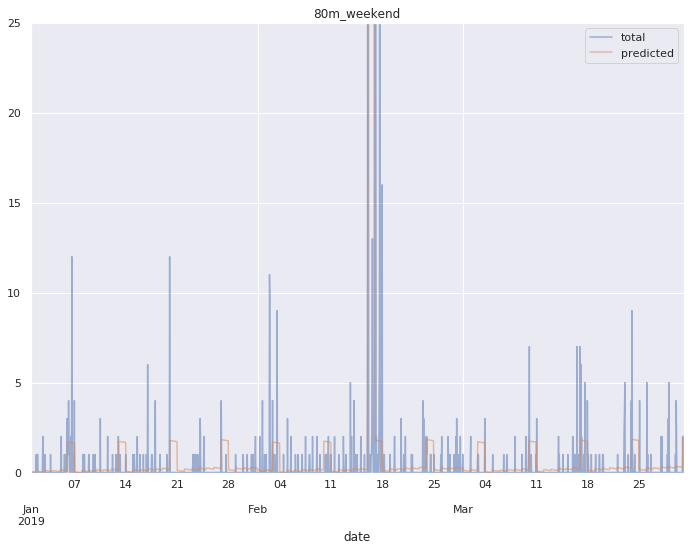

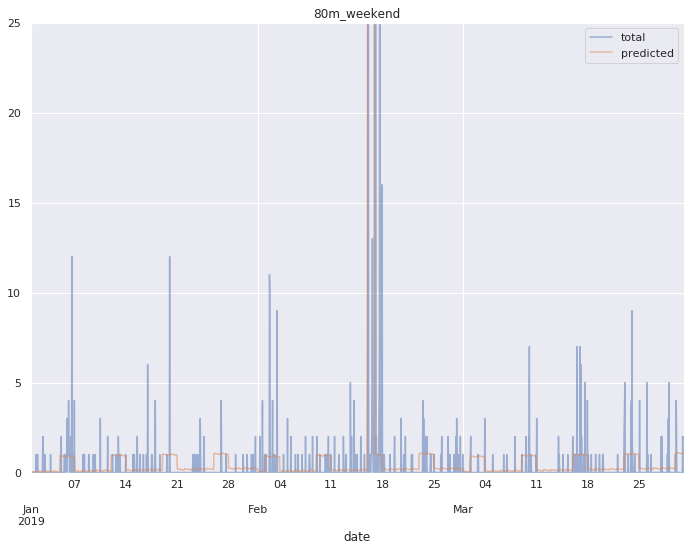

In [7]:
sns.set(rc={'figure.figsize': (11.7, 8.27), 'keymap.yscale': 'log'})

def plot_graph(lm):
    "Wrapper function for generating our graphs"
    lm.df[['total', 'predicted']].plot(alpha=0.5, title=m.name, ylim=(0,25))
    
plot_graph(loostmap_40m_day)
plot_graph(loostmap_40m_weekend)

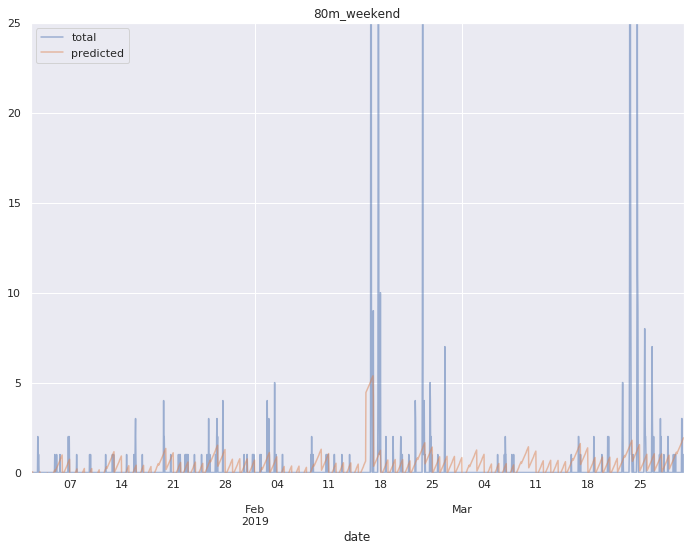

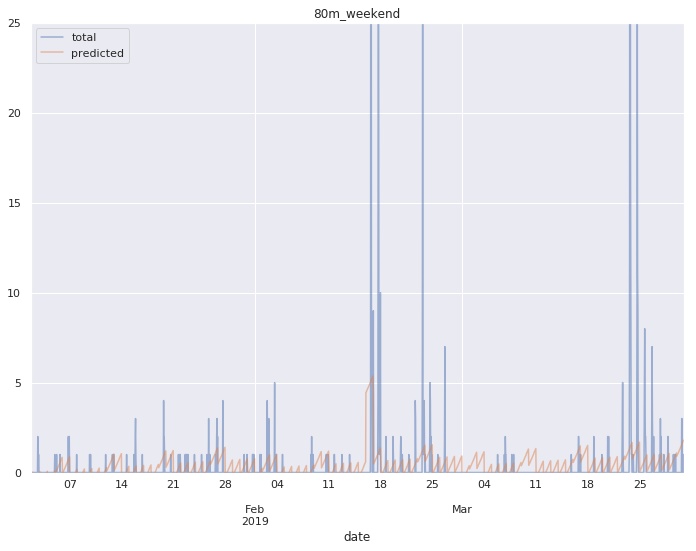

In [8]:
plot_graph(loostmap_20m_day)
plot_graph(loostmap_20m_weekend)

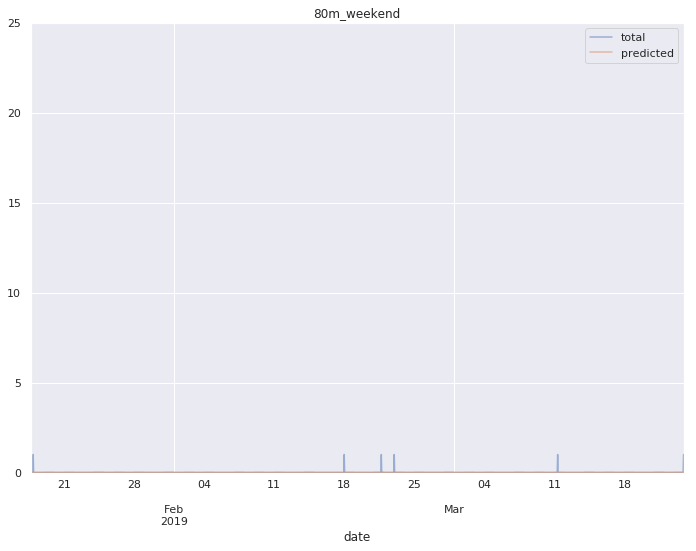

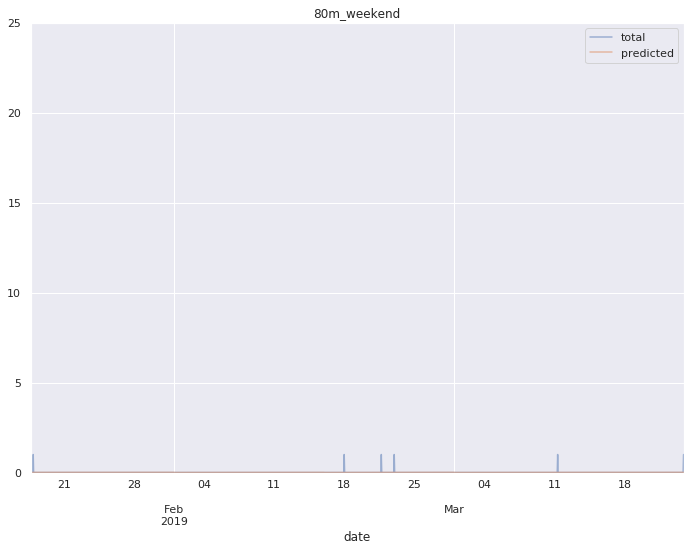

In [9]:
plot_graph(loostmap_30m_day)
plot_graph(loostmap_30m_weekend)

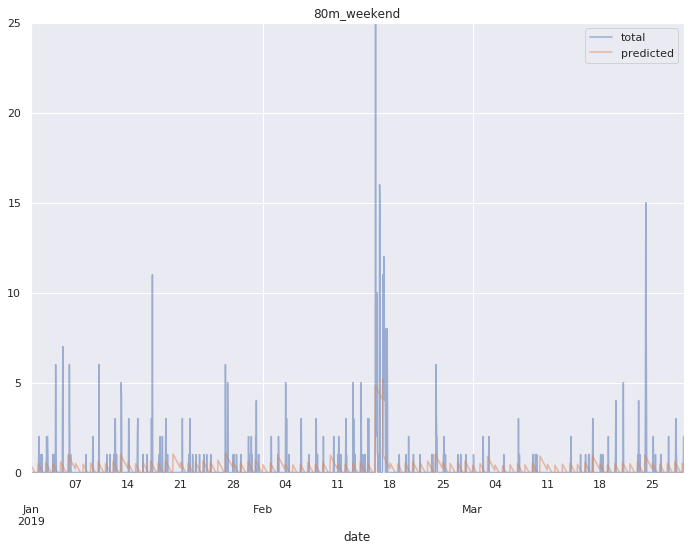

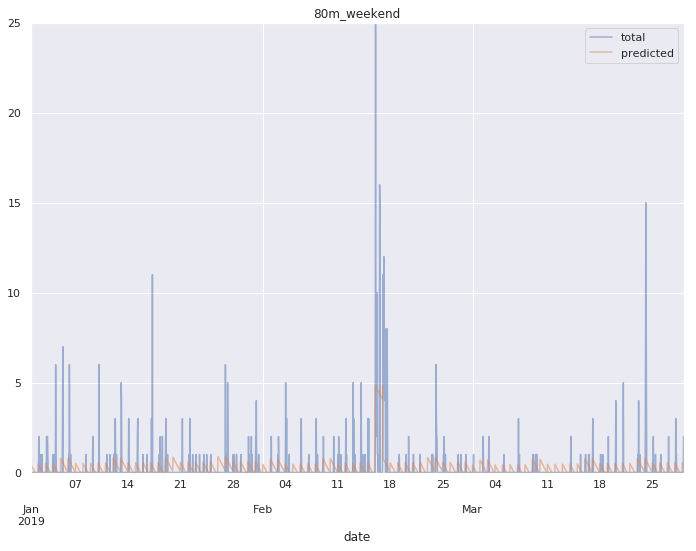

In [10]:
plot_graph(loostmap_80m_day)
plot_graph(loostmap_80m_weekend)

Now let's examine various error measurements.

**FIXME:** I'm not sure I understod the various error measurements correctly. I'd assumed these would be on a row-by-row basis, but it appears that they're over the dataset as a whole...which, given that they're mean, I might have guessed in advance. :-|


In [11]:
from sklearn import metrics

def print_error_measurements(lm):
    "Given a LoostmapModel, print various error measurements"
    total = lm.df.total
    predicted = lm.df.predicted
    print("Error measurements for %s:\n" % lm.name)
    print("Mean absolute error: %f" % metrics.mean_absolute_error(total, predicted))
    print("Mean squared error: %f" %  metrics.mean_squared_error(total, predicted))
    print("Root mean squared error: %f" % np.sqrt(metrics.mean_squared_error(total, predicted)))
    print("\n-------")

for m in all_models:
    print_error_measurements(m)

Error measurements for 20m_day:

Mean absolute error: 0.713890
Mean squared error: 8.523394
Root mean squared error: 2.919485

-------
Error measurements for 20m_weekend:

Mean absolute error: 0.713379
Mean squared error: 8.530089
Root mean squared error: 2.920632

-------
Error measurements for 30m_day:

Mean absolute error: 0.009494
Mean squared error: 0.004416
Root mean squared error: 0.066453

-------
Error measurements for 30m_weekend:

Mean absolute error: 0.008893
Mean squared error: 0.004444
Root mean squared error: 0.066663

-------
Error measurements for 40m_day:

Mean absolute error: 1.107312
Mean squared error: 62.378515
Root mean squared error: 7.898007

-------
Error measurements for 40m_weekend:

Mean absolute error: 1.093588
Mean squared error: 62.538989
Root mean squared error: 7.908160

-------
Error measurements for 80m_day:

Mean absolute error: 0.472046
Mean squared error: 1.749704
Root mean squared error: 1.322764

-------
Error measurements for 80m_weekend:

Mean

Now let's see how we did with cross-validation:

In [12]:
for m in all_models:
    m.print_xvalidate_accuracy(cv=25)

Accuracy for 20m_day: -2.19 (+/- 7.72)
Accuracy for 20m_weekend: -2.20 (+/- 9.03)
Accuracy for 30m_day: -0.00 (+/- 0.02)
Accuracy for 30m_weekend: -0.00 (+/- 0.02)
Accuracy for 40m_day: -0.97 (+/- 3.57)
Accuracy for 40m_weekend: -0.49 (+/- 1.70)
Accuracy for 80m_day: -0.29 (+/- 1.08)
Accuracy for 80m_weekend: -0.22 (+/- 0.83)


Finally, let's get some coefficients.

In [13]:
for m in all_models:
    print("%s: " % m.name)
    print(m.model_coef)
    print()

20m_day: 
hour               0.039250
month             -0.583730
annual             9.395352
Mon               -0.178775
Tue               -0.178410
Wed               -0.211509
Thu               -0.304557
Fri               -0.163570
Sat                0.651328
Sun                0.385494
arrl_dx_contest    3.903828
dtype: float64

20m_weekend: 
hour               0.039288
month             -0.565871
annual             9.226095
weekend            0.725699
arrl_dx_contest    4.027475
dtype: float64

30m_day: 
hour               0.000040
month             -0.004727
annual             0.057424
Mon                0.004725
Tue               -0.004692
Wed               -0.004849
Thu                0.008381
Fri               -0.004193
Sat                0.004961
Sun               -0.004334
arrl_dx_contest   -0.009320
dtype: float64

30m_weekend: 
hour               0.000045
month             -0.006018
annual             0.076445
weekend            0.000557
arrl_dx_contest   -0.005133
dtype: f

# So!

- We got a prediction
- We graphed the result
- The model we have shows strong correlation for the ARRL DX contest, the time of year, and whether it's a weekend/Sunday
- It kind of sucks most of the time, and it *really* sucks around Feb 18th -- even after adding the ARRL contest dates to the model
- Overall this has been good exploration, but it looks like a linear regression may not do much to predict this
  - ...though this *is* only with three months of data.

# Some notes about scoring

- According to [this discussion](https://github.com/iit-cs579/main/issues/30), `accuracy` is the wrong scoring mechanism to use for a linear regression.
- SciKitLearn's [overview of cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics) points to [the ability to pass in the scoring method](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).  There are a number of choices [listed here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for linear regressions.
- The `crossval` documentation mentions that if you don't specify a scorer, the default is used.  [The page for LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) seems to say that the default is the coefficient of determination R^2 of the prediction; the best score is 1.0, and it can be negative (because the model can be arbitrarily worse).  [This page](https://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination) has more detail.
- Given that the scoring mechanism in use is almost certainly the coefficient of determination, having the printout say "accuracy" is confusing and should be changed.

# TODO

- **DONE**: change `Count` to `total`
- **DONE**: one-hot encoding for day of week (to follow example)
- **DONE**: Make models for other bands (20, 30, 80)
- **DONE**: Better measurements for error, following [this article](https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606)
- **DONE:** Implement cross-validation for the models 
  - See [this StackExchange answer](https://stats.stackexchange.com/questions/193959/does-cross-validation-on-simple-or-multiple-linear-regression-make-sense) for discussion on the merits of cross-validation in regression models.  tl;dr: it can be useful when doing parameter estimation, and the *range* of parameters will also give you a sanity check.
  - [This article](https://towardsdatascience.com/linear-regression-in-python-9a1f5f000606) may also be helpful.
  - The confusing results up above need to be understood; why is the mean score 1 if it seems we're getting a lot of errors?
- **DONE:** Minor improvement: loop through array of dataframes (20m, 30m, etc) when calling `add_time_columns`
- **DONE:** Better understanding of what the error and accuracy measurements mean
- **DONE:** Compare accuracy when using weekend vs day-of-week


- Force predictions to be integers


- Look for ways to immprove predictions!
  - Add more features? (sunspots, more contests, sunrise/sun angle)
  - Remove some features?
  - Look for ways to ignore the ARRL DX outliers
  

- Log scale for error graph


- Better understanding of graphing; [this example](https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py), though in matplotlib, may come closer to what I want



- Better understanding of what linear regression "likes". I'm thinking here of what Max said about how normalizing data to range(0.0, 1.0) gives neural network better performance; is the same true here?


- It would be interesting to see what the accuracy would be or a slightly different question: what's the likelihood of th elocal skimmer picking up an EU station, no matter what the band?  Would turning the band into just another feature (rather than building separate models for each feature) make things better?